<style>
  table {
    font-size: 0.75em;
    border-collapse: collapse;
  }
  th, td {
    padding: 4px 6px;
    border: 1px solid #ccc;
  }
</style>
## 1. Introduction
The objective of this notebook is to present the modeling for the [Telco Customer Churn Dataset](https://www.kaggle.com/datasets/blastchar/telco-customer-churn/).

---

### 1.1 Conclusions
## Model Evaluation Summary

| Model                                 | Accuracy |
|--------------------------------------|----------|
| Random Forest (all features)         | 78.21%   |
| XGBoost (all features)               | **78.71%** |
| Decision Tree (all features)         | 73.24%   |
| LGBMClassifier (all features)        | 78.57%   |
| Random Forest (selected features)    | 78.57%   |
| XGBoost (selected features)          | 77.79%   |
| Decision Tree (selected features)    | 73.67%   |
| LGBMClassifier (selected features)   | 78.35%   |


### Limitations

- The churn class (0) shows lower precision and recall, which could be addressed in future iterations.

- I thought about exploring hyperparameter tuning, but I underestimated the time it would take (specially for me to understand this approach). I prefer to understand better this topic first before diving into that. In the future, I would definitely try a hyperparameter approach to see if performance can improve.

## 2. Import Libraries / Settings

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path

import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE

from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_curve, auc, precision_recall_curve
)
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [2]:
# Set the path to the dataset 
notebook_path = Path.cwd()
data_path = notebook_path.parent / "notebooks" / "data" / "02_churn_features_data.csv"

In [3]:
# Import the dataset
data = pd.read_csv(data_path)
data.columns = data.columns.str.replace(" ", "_")
data.head()

,gender,seniorcitizen,partner,dependents,tenure,phoneservice,contract,paperlessbilling,monthlycharges,totalcharges,...,streamingtv_no,streamingtv_no_internet_service,streamingtv_yes,streamingmovies_no,streamingmovies_no_internet_service,streamingmovies_yes,paymentmethod_bank_transfer,paymentmethod_credit_card,paymentmethod_electronic_check,paymentmethod_mailed_check
0,0,0,1,0,1,0,1,1,29.85,29.85,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,0,0,0,34,1,12,0,56.95,1889.50,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1,0,0,0,2,1,1,1,53.85,108.15,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1,0,0,0,45,0,12,0,42.30,1840.75,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0,0,0,0,2,1,1,1,70.70,151.65,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


# 3. Models

In [4]:
# Split dataset 
X = data.drop(columns=['churn'])
y = data['churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Shape of the data: Train={X_train.shape}, Test={X_test.shape}")

Shape of the data: Train=(5634, 38), Test=(1409, 38)


Here we can see a problem: the dataset is imbalanced, with a significant difference in the number of churned and non-churned customers. To address this, we will use the SMOTE technique to balance the dataset. 

"The simplest approach involves duplicating examples in the minority class, although these examples don’t add any new information to the model. Instead, new examples can be synthesized from the existing examples. This is a type of data augmentation for the minority class and is referred to as the Synthetic Minority Oversampling Technique, or SMOTE for short." [Machine Learning Mistery - SMOTE](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/)

In [5]:
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)
print(f"Shape of the balanced training data: {X_train_bal.shape}, {y_train_bal.shape}")

Shape of the balanced training data: (8278, 38), (8278,)


In [6]:
def evaluate_model(name, model, X_test, y_test):
    # Predictions
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for class 1

    print(f"Model Evaluation: {name}\n")

    # Preparar subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 4))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, 
                annot=True, 
                fmt="d", 
                cmap="Blues", 
                cbar=False, 
                ax=axes[0])
    axes[0].set_title(f'Confusion Matrix')
    axes[0].set_xlabel("Prediction")
    axes[0].set_ylabel("Real Value")

    # ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    axes[1].plot(fpr, 
                 tpr, 
                 color='darkorange', 
                 label=f'AUC = {roc_auc:.2f}')
    axes[1].plot([0, 1], [0, 1], color='navy', linestyle='--')
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title('ROC Curve')
    axes[1].legend(loc="lower right")

    # Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    axes[2].plot(recall, precision, color='green')
    axes[2].set_xlabel('Recall')
    axes[2].set_ylabel('Precision')
    axes[2].set_title('Precision-Recall Curve')
    axes[2].grid()

    plt.suptitle(name)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    # Accuracy
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {acc:.4f}\n")

    # Classification report
    print(" Classification Report:")
    print(classification_report(y_test, y_pred))

# 3.1 All Features

In [7]:
all_features = X_train_bal.columns.tolist() 

## Random Forest

Model Evaluation: Random Forest with all features



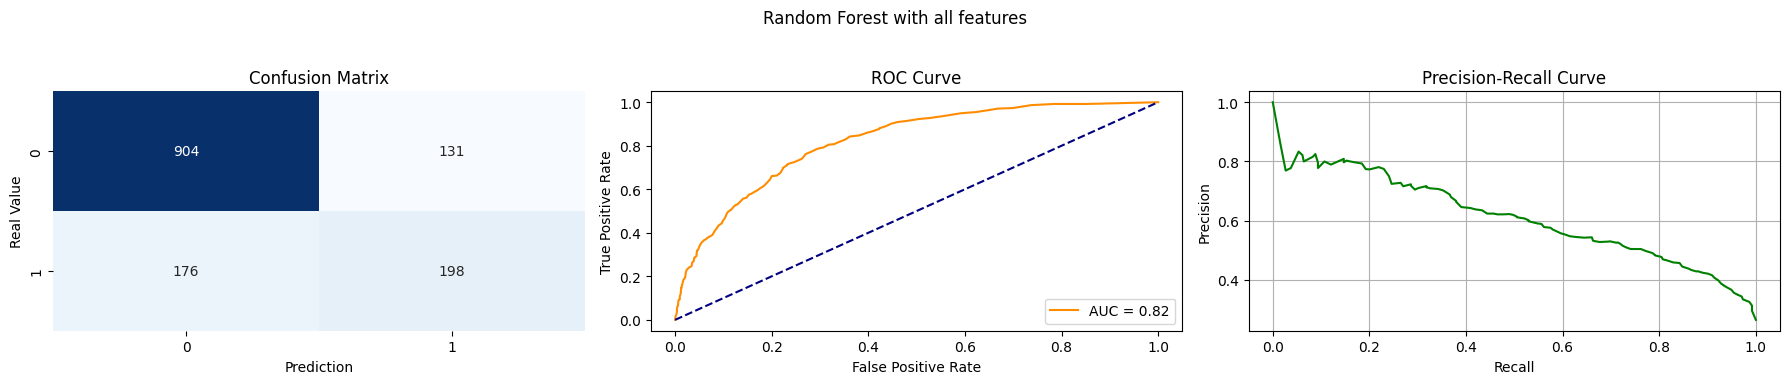

Accuracy: 0.7821

 Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.87      0.85      1035
           1       0.60      0.53      0.56       374

    accuracy                           0.78      1409
   macro avg       0.72      0.70      0.71      1409
weighted avg       0.77      0.78      0.78      1409



In [8]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_bal, y_train_bal)
evaluate_model("Random Forest with all features", rf_model, X_test, y_test)

- High precision (0.84) and recall (0.87) for class 0, indicating that the model successfully identifies churned customers.

- Lower precision (0.60) and recall (0.53) for class 1, suggesting difficulty in correctly predicting churned customers.

- ROC curve indicates good discrimination ability between classes, but there is room for improvement, especially in class 1.

- The Precision-Recall curve reflects the challenge with the minority class, where high recall values can compromise precision.

# XGBoost

Model Evaluation: XGBoost with all features



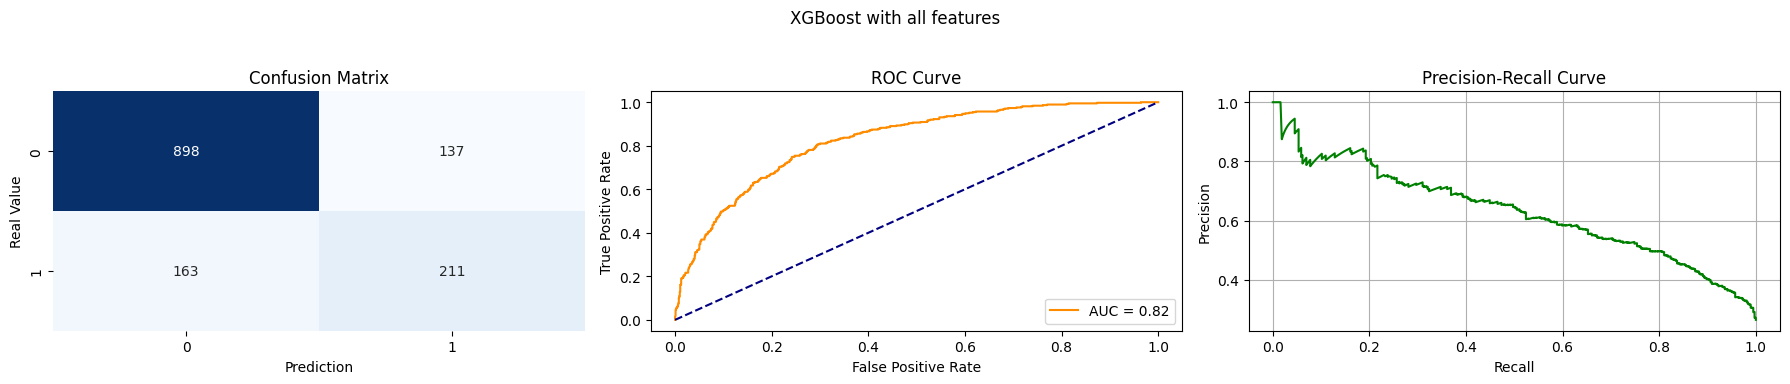

Accuracy: 0.7871

 Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.87      0.86      1035
           1       0.61      0.56      0.58       374

    accuracy                           0.79      1409
   macro avg       0.73      0.72      0.72      1409
weighted avg       0.78      0.79      0.78      1409



In [9]:
xgboost_model = XGBClassifier(random_state=42)
xgboost_model.fit(X_train_bal, y_train_bal)
evaluate_model("XGBoost with all features", xgboost_model, X_test, y_test)

- High precision (0.85) and recall (0.87) indicate effective identification of retained customers.

- Lower precision (0.61) and recall (0.56) suggest challenges in accurately predicting customer churn. such as happened with RandomForest.

- The ROC curve shows good class separation but highlights room for improvement, especially for the minority class.

- Overall model performance is decent, but class 1 metrics reveal a need for better handling in these cases.


# DecisionTree

Model Evaluation: Decision Tree with all features



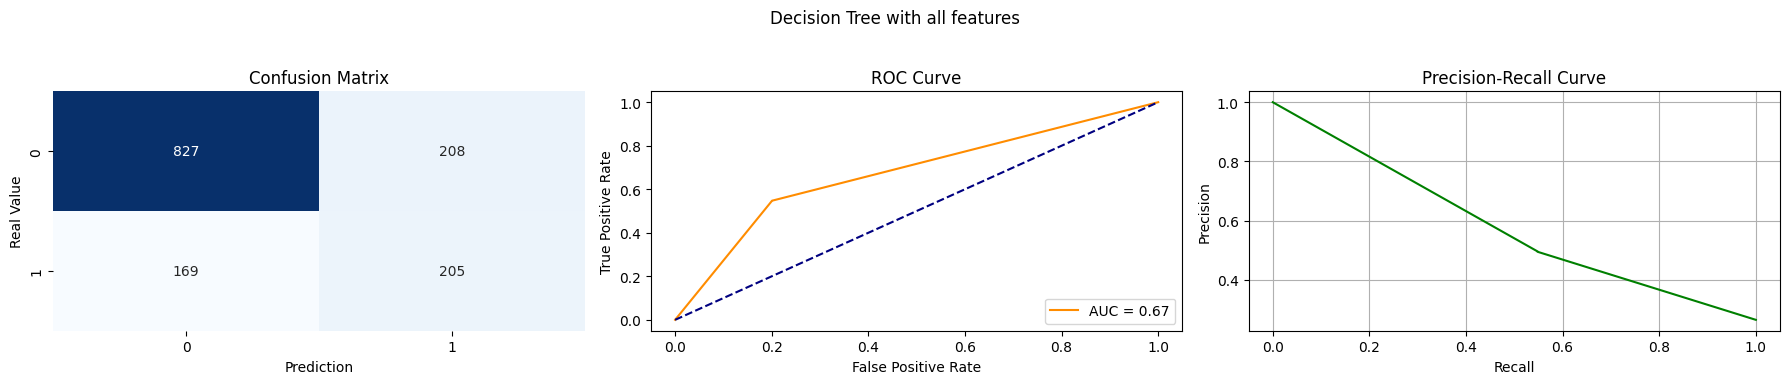

Accuracy: 0.7324

 Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.80      0.81      1035
           1       0.50      0.55      0.52       374

    accuracy                           0.73      1409
   macro avg       0.66      0.67      0.67      1409
weighted avg       0.74      0.73      0.74      1409



In [10]:
decision_tree_model = DecisionTreeClassifier(random_state=42)
decision_tree_model.fit(X_train_bal, y_train_bal)
evaluate_model("Decision Tree with all features", decision_tree_model, X_test, y_test)

- Lower accuracy (0.73) and AUC (0.67) compared to Random Forest and XGBoost.  

- Precision (0.50) and recall (0.55) for class 1 (churn) are the lowest among tested models.  

- Not a good approach for our problem. 

# LGBMClassifier

[LightGBM] [Info] Number of positive: 4139, number of negative: 4139
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001211 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5779
[LightGBM] [Info] Number of data points in the train set: 8278, number of used features: 38
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Model Evaluation: LGBMClassifier with all features



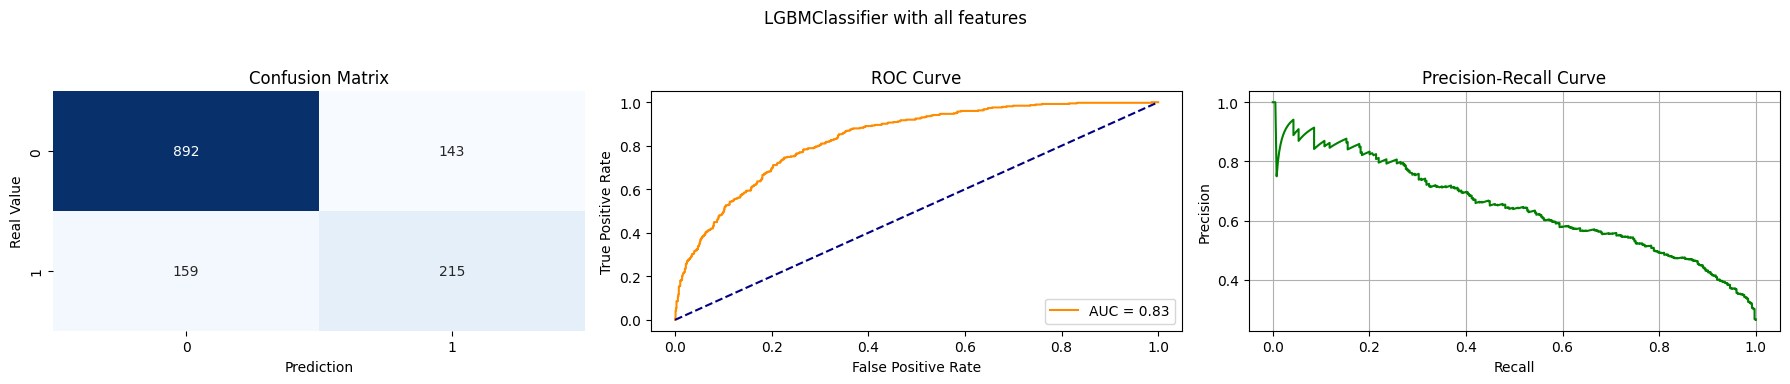

Accuracy: 0.7857

 Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.86      0.86      1035
           1       0.60      0.57      0.59       374

    accuracy                           0.79      1409
   macro avg       0.72      0.72      0.72      1409
weighted avg       0.78      0.79      0.78      1409



In [11]:
lgbm_model = LGBMClassifier(random_state=42)
lgbm_model.fit(X_train_bal, y_train_bal)
evaluate_model("LGBMClassifier with all features", lgbm_model, X_test, y_test)

- Strong precision (0.85) and recall (0.86) for class 0, with acceptable metrics (0.60 precision, 0.57 recall) for class 1.

- Superior class separation compared to other models, indicating better overall discriminative power.

-  Same as other motels: while better than Decision Tree, still struggles with churn prediction (class 1).

- Maintains competitive accuracy (0.79) with lighter computational demands than XGBoost/Random Forest.

# 3.2 Feature Selection

In [12]:
# Feature Selection
selector = RFECV(estimator=DecisionTreeClassifier(), step=1, cv=StratifiedKFold(5))
selector = selector.fit(X_train_bal, y_train_bal)
selected_features = X_train_bal.columns[selector.support_]

# To a better reproducibility, these are the selected features for the next evaluations
selected_features = ['tenure', 'contract', 'paperlessbilling', 'monthlycharges', 'totalcharges', 'onlinesecurity_no', 'onlinebackup_no', 'techsupport_no', 'streamingmovies_yes', 'paymentmethod_electronic_check']

# Random Forest

Model Evaluation: Random Forest with selected features



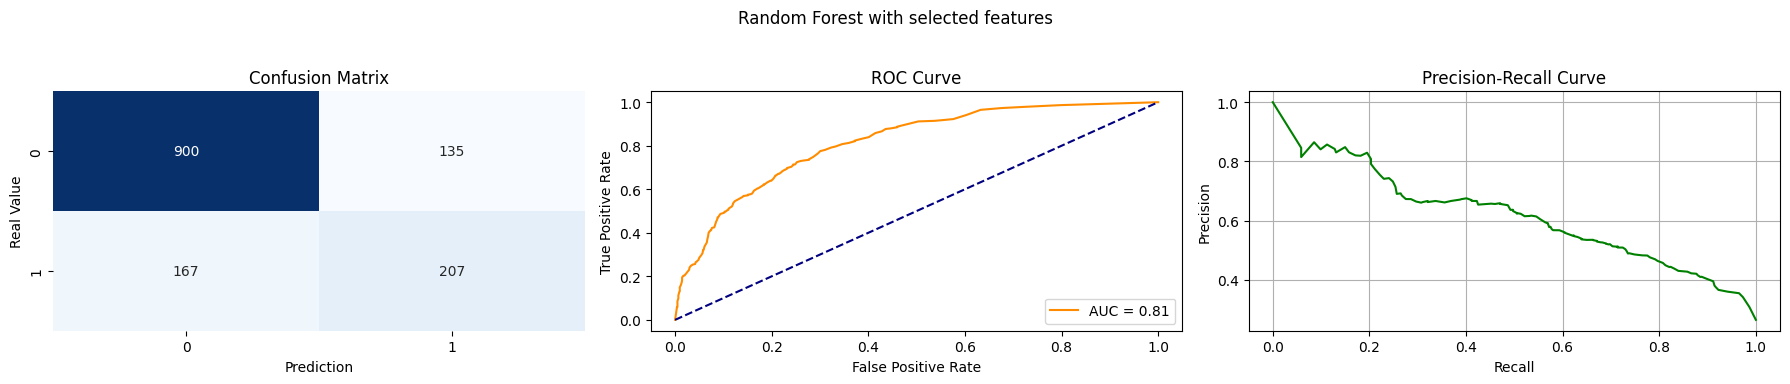

Accuracy: 0.7857

 Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.87      0.86      1035
           1       0.61      0.55      0.58       374

    accuracy                           0.79      1409
   macro avg       0.72      0.71      0.72      1409
weighted avg       0.78      0.79      0.78      1409



In [13]:
rf_model_fs = RandomForestClassifier(random_state=42)
rf_model_fs.fit(X_train_bal[selected_features], y_train_bal)
evaluate_model("Random Forest with selected features", rf_model_fs, X_test[selected_features], y_test)

- Accuracy (0.79) and AUC (0.81) show minor drops compared to the full-feature model

- Maintains strong precision (0.84) and recall (0.87) for class 0 despite fewer features.

- Class 1 metrics (precision/recall 0.55) remain low.

# XGBoost

Model Evaluation: XGBoost with selected features



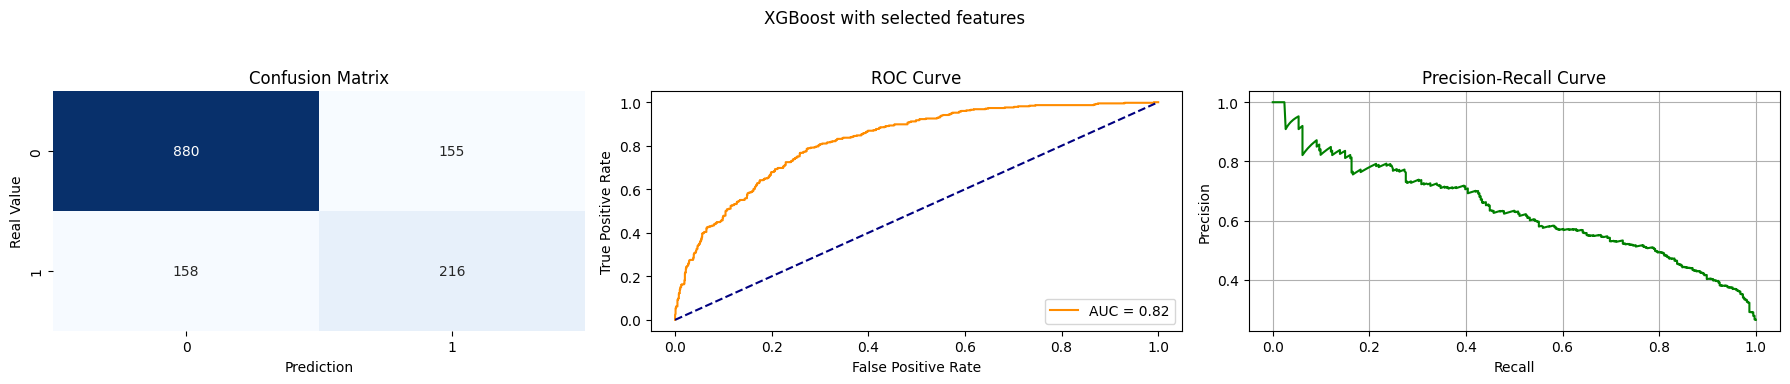

Accuracy: 0.7779

 Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      1035
           1       0.58      0.58      0.58       374

    accuracy                           0.78      1409
   macro avg       0.71      0.71      0.71      1409
weighted avg       0.78      0.78      0.78      1409



In [14]:
xgboost_model_fs = XGBClassifier(random_state=42)
xgboost_model_fs.fit(X_train_bal[selected_features], y_train_bal)
evaluate_model("XGBoost with selected features", xgboost_model_fs, X_test[selected_features], y_test)

- Keeps almost the same values as the model with all features, precision (0.85) and recall (0.85) for class 0 remain strong.

- Lower precision (0.58) and recall (0.58), we have the same problem as before.

# Decision Tree

Model Evaluation: Decision Tree with selected features



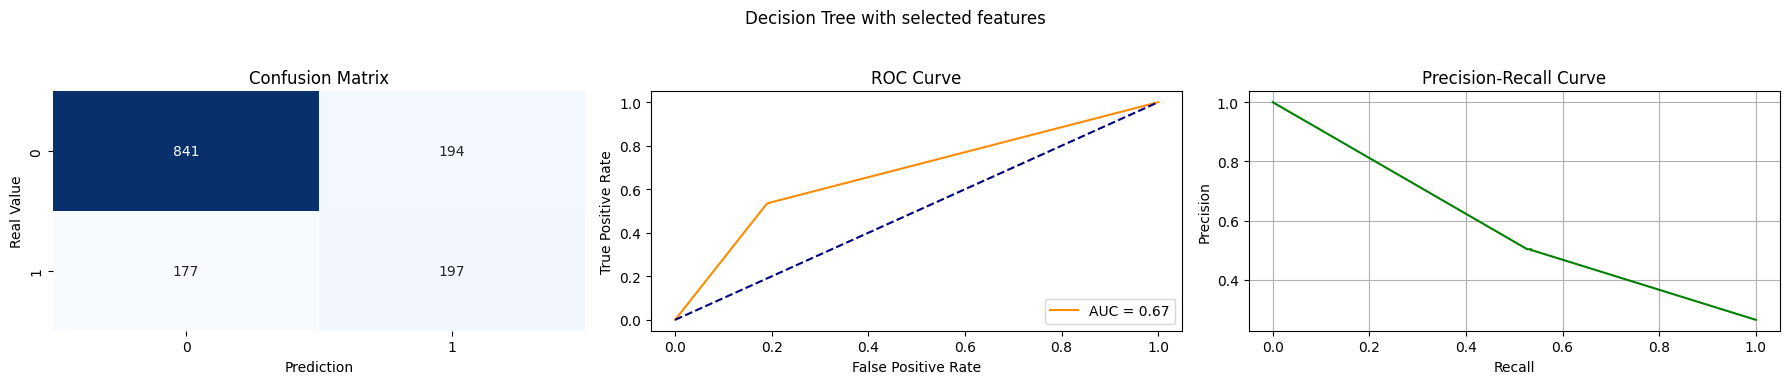

Accuracy: 0.7367

 Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.81      0.82      1035
           1       0.50      0.53      0.52       374

    accuracy                           0.74      1409
   macro avg       0.66      0.67      0.67      1409
weighted avg       0.74      0.74      0.74      1409



In [15]:
decision_tree_model_fs = DecisionTreeClassifier(random_state=42)
decision_tree_model_fs.fit(X_train_bal[selected_features], y_train_bal)
evaluate_model("Decision Tree with selected features", decision_tree_model_fs, X_test[selected_features], y_test)

- The model achieves an accuracy of 73%, indicating it performs reasonably well in predicting churn but leaves room for improvement.

- Precision and recall for class 1 (churn) are notably lower (precision: 0.50, recall: 0.53) compared to class 0 (no churn), suggesting the model struggles more with correctly identifying churned customers.

- The macro average F1-score is 0.67, while the weighted average is 0.74, highlighting that the model favors the majority class (non-churn), which may be problematic in churn-sensitive applications.

# LGBMClassifier

[LightGBM] [Info] Number of positive: 4139, number of negative: 4139
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000128 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1885
[LightGBM] [Info] Number of data points in the train set: 8278, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Model Evaluation: LGBMClassifier with selected features



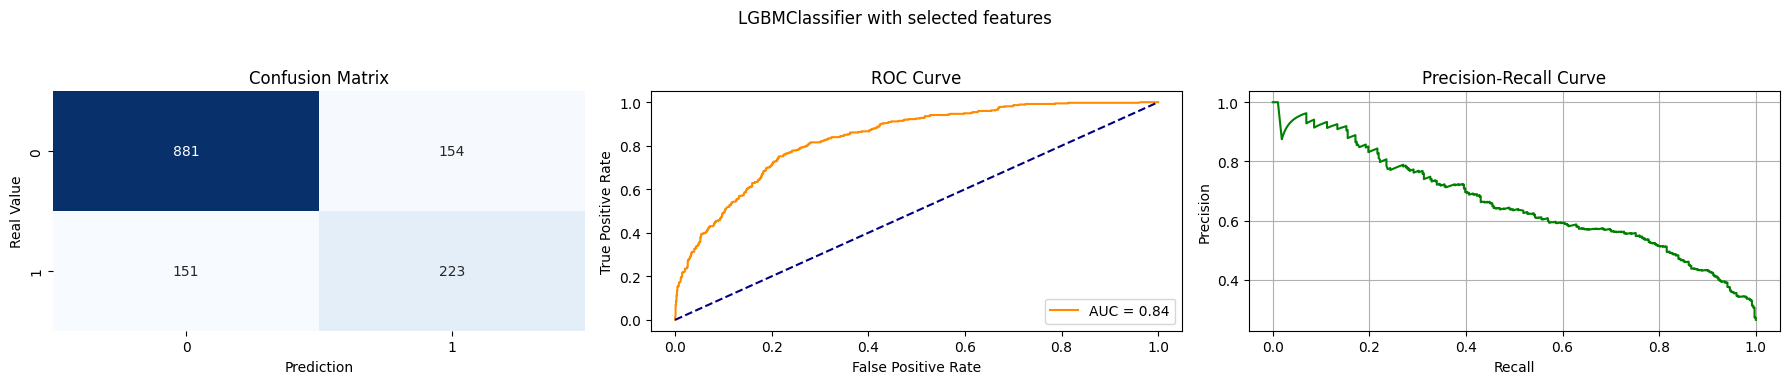

Accuracy: 0.7835

 Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      1035
           1       0.59      0.60      0.59       374

    accuracy                           0.78      1409
   macro avg       0.72      0.72      0.72      1409
weighted avg       0.78      0.78      0.78      1409



In [16]:
lgbm_model_fs = LGBMClassifier(random_state=42)
lgbm_model_fs.fit(X_train_bal[selected_features], y_train_bal)
evaluate_model("LGBMClassifier with selected features", lgbm_model_fs, X_test[selected_features], y_test)

- The model achieves an accuracy of 78%, indicating reliable performance in predicting customer churn.

- Compared to previous models, it shows better balance in identifying churned customers (precision: 0.59, recall: 0.60)

- The macro average F1-score of 0.72 reflects consistent performance across both churn and non-churn classes, making it a well-rounded model.